# Purpose: Forecasting Smoke Impact's on Respiratory Mortality
The goal of `social_impact_execution.ipynb` is to do analysis on wildfire's smoke impact on respiratory mortality in Gresham, Oregon (OR). 
This will be done using a correlation analysis to find the relevant respiratory illnesses that smoke impact affects, and using historical smoke and respiratory mortality data, the trends of respiratory mortality will be forecasted through 2025-2050.

The `smoke_data`, which contains the estimated smoke impact of each wildfire that we calculated in `common_analysis.ipynb`. The respiratory mortality data, `mortality_by_disease_and_year.csv`, for each disease in Multonomah county, which Gresham, OR is apart of, was cleaned in `social_impact_preprocessing.ipynb`. 


# Step 0: Load the data & libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.linear_model import LinearRegression

In [33]:
smoke_data = pd.read_csv('output_files/smoke_impact_estimates1.csv')
mortality_by_disease_and_year = pd.read_csv('intermediary_files/mortality_by_disease_and_year.csv')

mortality_by_disease_and_year.head()

,year_id,total_mortality
0,1980,1770.496354
1,1981,1746.701757
2,1982,1795.569581
3,1983,1734.479396
4,1984,1828.568555


In [5]:
smoke_data.head()

,Year,Fire_Name,Fire_Size_Acres,Distance_to_City_Miles,Smoke_Impact
0,1961,4 MILE (4),1702.881869,306.363628,0.018143
1,1961,A. W. WALDO (5),470.326850,422.547385,0.002634
2,1961,AUBURN (10),1091.017064,461.659039,0.005119
3,1961,AUSTRIAN GULCH (5),9071.436292,576.427961,0.027301
4,1961,Alkali\n (2),0.745750,545.904870,0.000003


# Step 1: Aggregate Smoke Impact by Year
The output file `smoke_impact_estimates1.csv` from `common_analysis,ipynb` contains each wildfire that occured in Gresham, OR within a 1800 mile radius on the city. The original radius for forecasting in the assignment was 650 miles, so I will be filtering down to wildfires occuring within 650 miles and getting the annual smoke impact by grouping by each fire that occured within a year. 

In [21]:
# fires within 650, used for smoke estimate
close_fires_df = smoke_data[smoke_data['Distance_to_City_Miles'] <= 650]

close_fires_df["Year"] = close_fires_df["Year"].astype(int)

# calculating the total smoke impact per year by summing impacts for each year
annual_smoke_impact = close_fires_df.groupby("Year")["Smoke_Impact"].sum().reset_index(name='total_smoke_impact')


/var/folders/j_/vc3ydh9x0l3dty8vdsjkb0_80000gn/T/ipykernel_3020/585150210.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_fires_df["Year"] = close_fires_df["Year"].astype(int)


# Step 2: Merge the Data & Do a Correlation Analysis
Now that we have the data in the format we need, we can merge the data to get the annual smoke impact and annual mortality per chronic respiratory disease. 

The next step is to do a correlation analysis to see how the diseases affect each other and the smoke impact. 

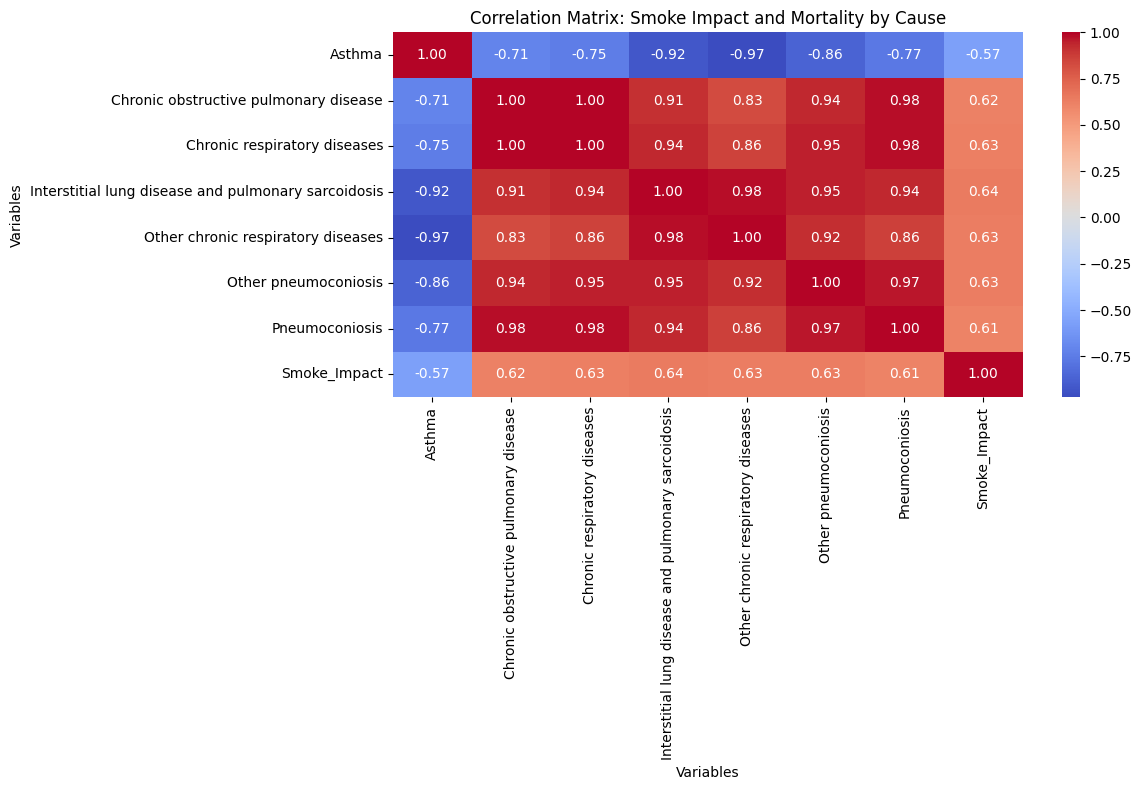

In [39]:
# Merge mortality and smoke impact data
merged_data = pd.merge(
    mortality_by_disease_and_year,
    annual_smoke_impact,
    left_on='year_id',
    right_on='Year',
    how='inner'
)

# Pivot mortality data so each cause is a separate column
mortality_pivot = merged_data.pivot(index='year_id', columns='cause_name', values='mortality')

# Add smoke impact as a column for correlation analysis
mortality_pivot['Smoke_Impact'] = merged_data.groupby('year_id')['total_smoke_impact'].first()

# Calculate correlations only between Smoke Impact and the causes
smoke_correlation = mortality_pivot.corrwith(mortality_pivot['Smoke_Impact']).drop('Smoke_Impact')

# Display the correlations
print(smoke_correlation)


It appears that the diseases are highly correlated with each other, likely because chronic respiratory diseases is encompassing of the other diseases.

For the sake of the assignment, we are more concerned with how smoke_impact is correlated with each of the diseases rather than how the diseases are correlated with each other. Below is a heatmap visualization of correlation between `Smoke_Impact` and the respiratory diseases.

Cause           Asthma  Chronic obstructive pulmonary disease  \
Smoke_Impact -0.568138                               0.617405   

Cause         Chronic respiratory diseases  \
Smoke_Impact                      0.628563   

Cause         Interstitial lung disease and pulmonary sarcoidosis  \
Smoke_Impact                                           0.644136     

Cause         Other chronic respiratory diseases  Other pneumoconiosis  \
Smoke_Impact                            0.634202               0.63078   

Cause         Pneumoconiosis  
Smoke_Impact        0.610461  


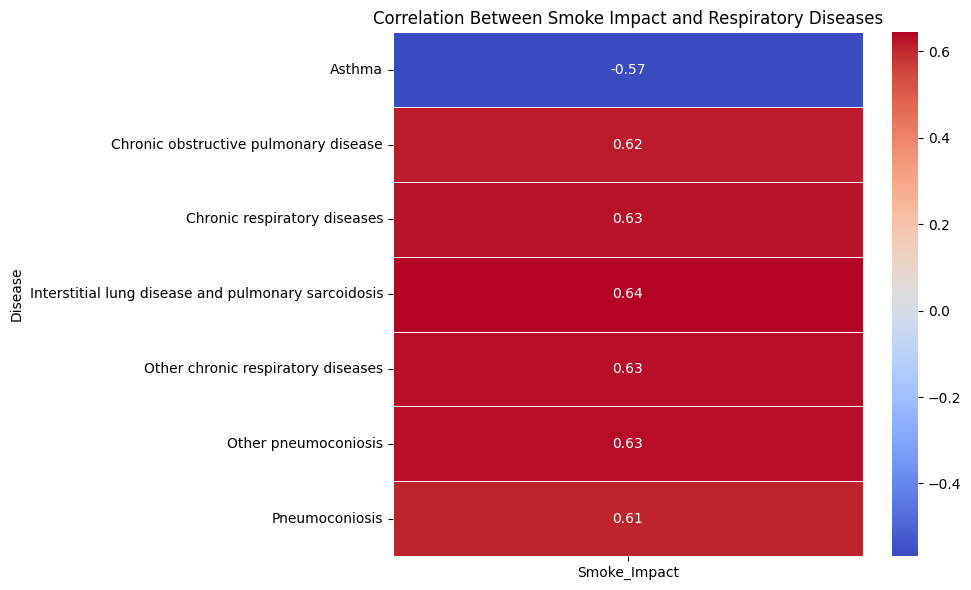

In [87]:
# Reshape correlation results for desired format
smoke_correlation_reshaped = pd.DataFrame(smoke_correlation).T

# Rename the index and column for clarity
smoke_correlation_reshaped.index = ["Smoke_Impact"]
smoke_correlation_reshaped.columns.name = "Cause"

# Reshape the correlation results for heatmap format
smoke_correlation_heatmap = pd.DataFrame(smoke_correlation, columns=["Smoke_Impact"])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    smoke_correlation_heatmap,
    annot=True,
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5
)

# Formatting the heatmap
plt.title("Correlation Between Smoke Impact and Respiratory Diseases")
plt.ylabel("Disease")
plt.tight_layout()
plt.show()


From our correlation analysis, it appears all respiratory illnesses are positively correlated with our smoke impact, meaning as the smoke from wildfires -- or PM2.5 exposure -- increases, the mortality rate for the positively correlated diseases also increase.

Asthma mortality was negatively correlated, likely due to it's preventability with proper healthcare.

# Step 3: Forecasting Smoke's Impact on Respiratory Mortality 


In [79]:
# List of diseases that are positively correlated with smoke impact
diseases_of_interest = [
    "Chronic respiratory diseases",
    "Chronic obstructive pulmonary disease",
    "Interstitial lung disease and pulmonary sarcoidosis",
    "Other chronic respiratory diseases",
    "Other pneumoconiosis",
    "Pneumoconiosis"
]

23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/j_/vc3ydh9x0l3dty8vdsjkb0_80000gn/T/ipykernel_3020/3437261890.py:18: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.DataFrame({"ds": pd.date_range(start="2025-01-01", end="2050-12-31", freq="Y")})
/Users/sarahnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/sarahnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/sarahnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/sarahnguyen/Library/Python/3.9/

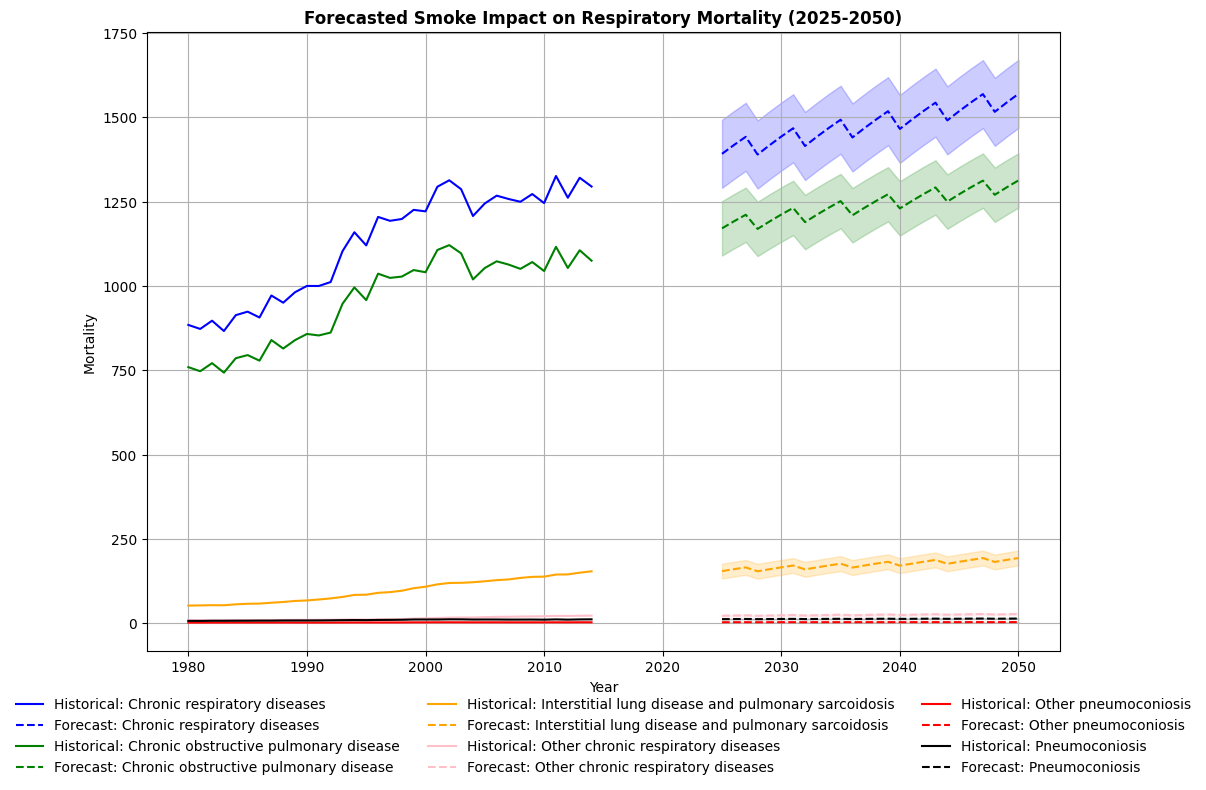

In [89]:
# Step 1: Prepare Smoke Impact Data for Prophet
annual_smoke_impact_1980_2014 = annual_smoke_impact[
    (annual_smoke_impact["Year"] >= 1980) & (annual_smoke_impact["Year"] <= 2014)
]
prophet_data = annual_smoke_impact_1980_2014.rename(columns={"Year": "ds", "total_smoke_impact": "y"})

# Step 2: Train Prophet Model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Step 3: Forecast Smoke Impact for 2025-2050
future_years = pd.DataFrame({"ds": pd.date_range(start="2025-01-01", end="2050-12-31", freq="Y")})
prophet_forecast = prophet_model.predict(future_years)

# Extract forecasted values and merge with historical data
prophet_forecasted_smoke_impact = pd.DataFrame({
    "Year": future_years["ds"].dt.year,
    "Smoke_Impact": prophet_forecast["yhat"]
})
dynamic_smoke_impact = pd.concat([
    annual_smoke_impact_1980_2014.rename(columns={"total_smoke_impact": "Smoke_Impact"}),
    prophet_forecasted_smoke_impact
])

# Step 4: Use Forecasted Smoke Impact in Linear Regression
filtered_data = mortality_by_disease_and_year[
    (mortality_by_disease_and_year["cause_name"].isin(diseases_of_interest)) &
    (mortality_by_disease_and_year["year_id"] >= 1980) &
    (mortality_by_disease_and_year["year_id"] <= 2014)
]

# Pivot the data so diseases are columns
pivoted_data = filtered_data.pivot(index="year_id", columns="cause_name", values="mortality")
pivoted_data["Smoke_Impact"] = dynamic_smoke_impact[
    dynamic_smoke_impact["Year"].isin(range(1980, 2015))
]["Smoke_Impact"].values

# Train Linear Regression Models
X_train = pivoted_data["Smoke_Impact"].values.reshape(-1, 1)
linear_models = {}
forecasts = {}

for disease in diseases_of_interest:
    y_train = pivoted_data[disease]
    model = LinearRegression()
    model.fit(X_train, y_train)
    linear_models[disease] = model
    forecasts[disease] = model.predict(prophet_forecasted_smoke_impact[["Smoke_Impact"]])

# Step 5: Plot Results with Unified Colors for Historical and Forecast
plt.figure(figsize=(12, 8))

colors = ["blue", "green", "orange", "pink", "red", "black"]  # Define colors for each disease

for i, disease in enumerate(diseases_of_interest):
    # Historical data
    plt.plot(
        pivoted_data.index,
        pivoted_data[disease],
        label=f"Historical: {disease}",
        linestyle="-",
        color=colors[i]
    )
    # Forecasted data with a dashed line
    plt.plot(
        prophet_forecasted_smoke_impact["Year"],
        forecasts[disease],
        label=f"Forecast: {disease}",
        linestyle="--",
        color=colors[i]
    )
    # Confidence interval shading
    lower_bound = forecasts[disease] - 1.96 * np.std(forecasts[disease])
    upper_bound = forecasts[disease] + 1.96 * np.std(forecasts[disease])
    plt.fill_between(
        prophet_forecasted_smoke_impact["Year"],
        lower_bound,
        upper_bound,
        alpha=0.2,
        color=colors[i]
    )

# Plot formatting
plt.xlabel("Year")
plt.ylabel("Mortality")
plt.title("Forecasted Smoke Impact on Respiratory Mortality (2025-2050)", fontweight = "bold")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.22), ncol=3, frameon=False)  # Legend at the bottom
plt.grid(True)
plt.tight_layout()
plt.show()